**ARECANUT DISEASE PREDICTION**

**IMPORT THE IMPORTANT PACKAGES**

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
import tensorflow as tf
from tensorflow import keras
from keras import layers
from keras.models import Sequential
from tqdm import tqdm
import cv2

import imutils

ModuleNotFoundError: No module named 'matplotlib'

In [2]:
!pip install imutils

Defaulting to user installation because normal site-packages is not writeable


In [ ]:
!pip install tqdm

: 

## Downloading The Dataset

In [ ]:

training="Arecanut_dataset/train"
testing="Arecanut_dataset/test"

# Image Preprocessing

In [ ]:
def crop_img(img):
	"""
	Finds the extreme points on the image and crops the rectangular out of them
	"""
	gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
	gray = cv2.GaussianBlur(gray, (3, 3), 0)

	# threshold the image, then perform a series of erosions +
	# dilations to remove any small regions of noise
	thresh = cv2.threshold(gray, 45, 255, cv2.THRESH_BINARY)[1]
	thresh = cv2.erode(thresh, None, iterations=2)
	thresh = cv2.dilate(thresh, None, iterations=2)

	# find contours in thresholded image, then grab the largest one
	cnts = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
	cnts = imutils.grab_contours(cnts)
	c = max(cnts, key=cv2.contourArea)

	# find the extreme points
	extLeft = tuple(c[c[:, :, 0].argmin()][0])
	extRight = tuple(c[c[:, :, 0].argmax()][0])
	extTop = tuple(c[c[:, :, 1].argmin()][0])
	extBot = tuple(c[c[:, :, 1].argmax()][0])
	ADD_PIXELS = 0
	new_img = img[extTop[1]-ADD_PIXELS:extBot[1]+ADD_PIXELS, extLeft[0]-ADD_PIXELS:extRight[0]+ADD_PIXELS].copy()

	return new_img

if __name__ == "__main__":
	training = "Arecanut_dataset/train"
	testing = "Arecanut_dataset/test"
	training_dir = os.listdir(training)
	testing_dir = os.listdir(testing)
	IMG_SIZE = 256

	for dir in training_dir:
		save_path = 'Arecanut_dataset/train'+ dir
		path = os.path.join(training,dir)
		image_dir = os.listdir(path)
		for img in image_dir:
			image = cv2.imread(os.path.join(path,img))
			new_img = crop_img(image)
			new_img = cv2.resize(new_img,(IMG_SIZE,IMG_SIZE))
			if not os.path.exists(save_path):
				os.makedirs(save_path)
			cv2.imwrite(save_path+'/'+img, new_img)

	for dir in testing_dir:
		save_path = 'Arecanut_dataset/test'+ dir
		path = os.path.join(testing,dir)
		image_dir = os.listdir(path)
		for img in image_dir:
			image = cv2.imread(os.path.join(path,img))
			new_img = crop_img(image)
			new_img = cv2.resize(new_img,(IMG_SIZE,IMG_SIZE))
			if not os.path.exists(save_path):
				os.makedirs(save_path)
			cv2.imwrite(save_path+'/'+img, new_img)

## Create a dataset

In [4]:
batch_size = 32
img_height = 256
img_width = 256

In [5]:
train_ds = tf.keras.utils.image_dataset_from_directory(
  "Arecanut_dataset/train",
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 8847 files belonging to 9 classes.
Using 7078 files for training.


In [6]:
val_ds = tf.keras.utils.image_dataset_from_directory(
  "Arecanut_dataset/test",
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 2217 files belonging to 9 classes.
Using 443 files for validation.


In [7]:
class_names = train_ds.class_names
print(class_names)

['Healthy_Leaf', 'Healthy_Nut', 'Healthy_Trunk', 'Mahali_Koleroga', 'Stem_bleeding', 'bud borer', 'healthy_foot', 'stem cracking', 'yellow leaf disease']


## Visualize the data

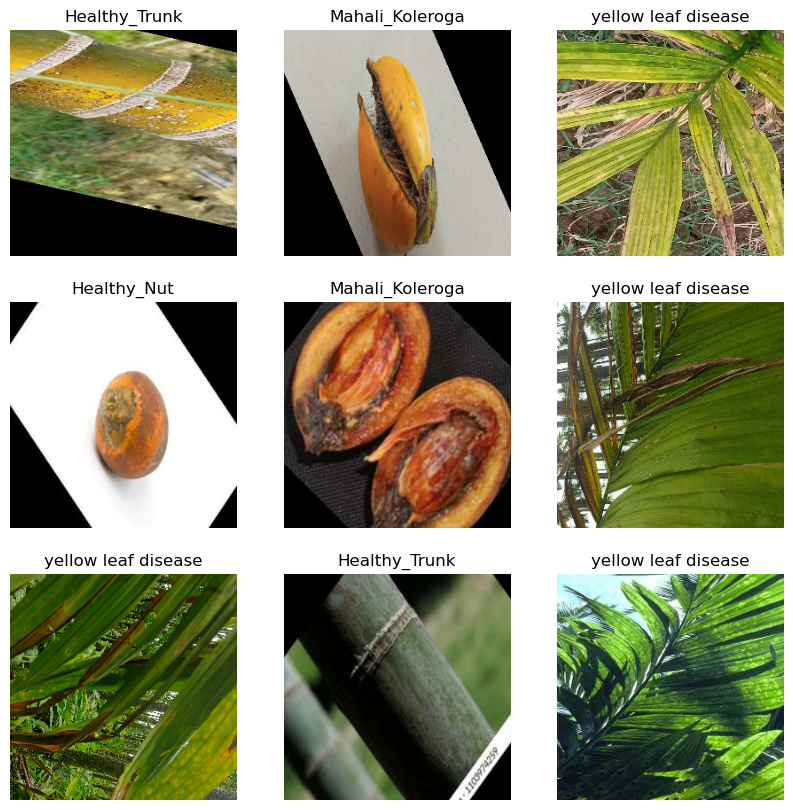

In [8]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [9]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 256, 256, 3)
(32,)


## Configure the dataset for performance

In [10]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

## Standardize the data

In [11]:
normalization_layer = layers.Rescaling(1./255)

In [12]:
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
# Notice the pixel values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image))

0.0 1.0


## Create the model

In [13]:
num_classes = len(class_names)

model = Sequential([
  layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes, activation='softmax')
])

## Compile the model

In [14]:
model.compile(optimizer='adam',
              loss="sparse_categorical_crossentropy",
              metrics=['accuracy'])

## Model summary

In [15]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_1 (Rescaling)     (None, 256, 256, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 256, 256, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2  (None, 128, 128, 16)      0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 128, 128, 32)      4640      
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 64, 64, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 64, 64, 64)        1

## Train the model

In [16]:
epochs=10
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs, batch_size=32
)

Epoch 1/10


222/222 [==============================] - 84s 365ms/step - loss: 0.9807 - accuracy: 0.6474 - val_loss: 0.7061 - val_accuracy: 0.7269
Epoch 2/10
222/222 [==============================] - 75s 339ms/step - loss: 0.3851 - accuracy: 0.8610 - val_loss: 0.3692 - val_accuracy: 0.8691
Epoch 3/10
222/222 [==============================] - 76s 341ms/step - loss: 0.1832 - accuracy: 0.9367 - val_loss: 0.3531 - val_accuracy: 0.8871
Epoch 4/10
222/222 [==============================] - 78s 353ms/step - loss: 0.0921 - accuracy: 0.9685 - val_loss: 0.4959 - val_accuracy: 0.8758
Epoch 5/10
222/222 [==============================] - 76s 344ms/step - loss: 0.0724 - accuracy: 0.9777 - val_loss: 0.3732 - val_accuracy: 0.9052
Epoch 6/10
222/222 [==============================] - 75s 339ms/step - loss: 0.0277 - accuracy: 0.9904 - val_loss: 0.2965 - val_accuracy: 0.9391
Epoch 7/10
222/222 [==============================] - 76s 341ms/step - loss: 0.0225 - accuracy: 0.9932 - val_loss: 0.4255 - val_

## Visualize training results

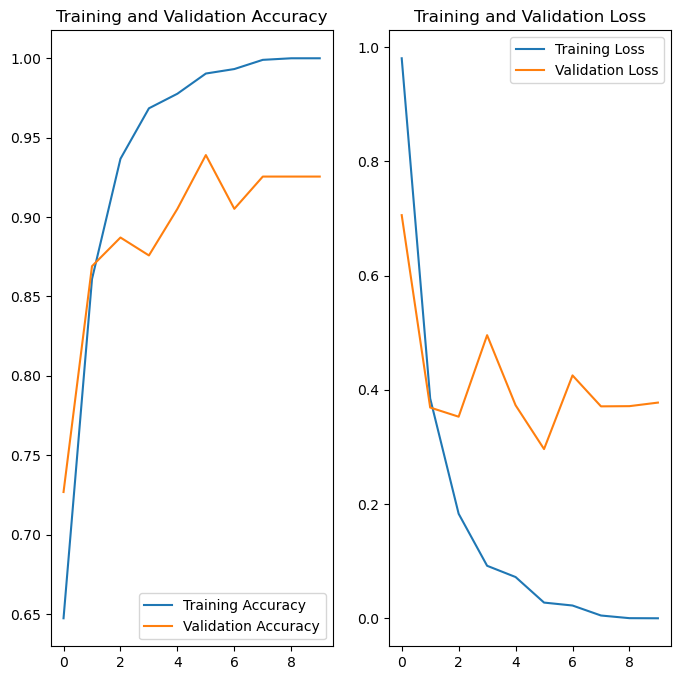

In [17]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

## Data augmentation

In [18]:
data_augmentation = keras.Sequential(
  [
    layers.RandomFlip("horizontal",
                      input_shape=(img_height,
                                  img_width,
                                  3)),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
  ]
)

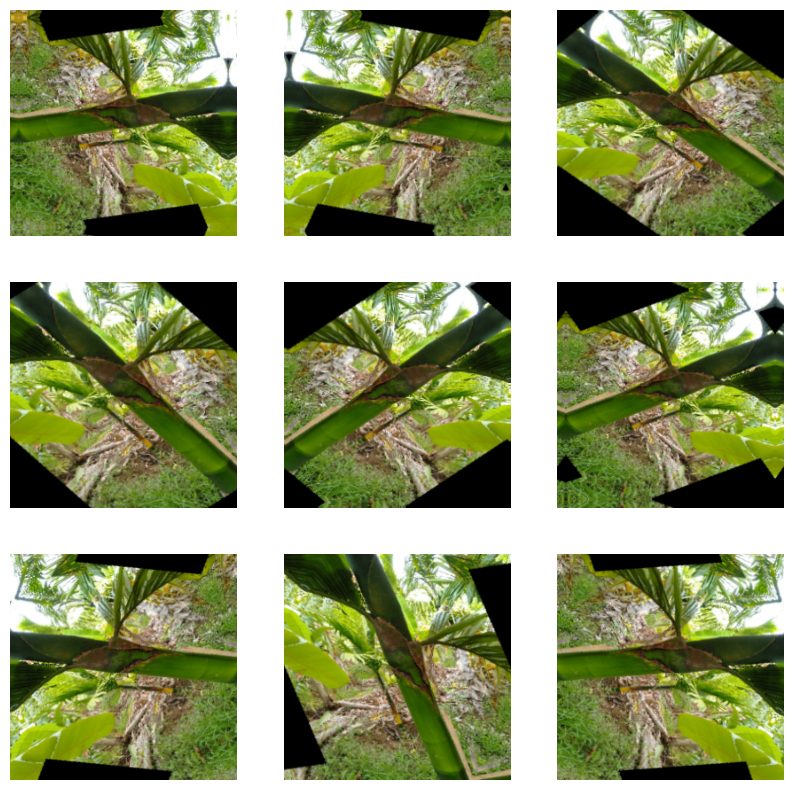

In [19]:
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
  for i in range(9):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[0].numpy().astype("uint8"))
    plt.axis("off")

## Dropout

In [20]:
model = Sequential([
  data_augmentation,
  layers.Rescaling(1./255),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes, activation='softmax')
])

## Compile and train the model

In [21]:
model.compile(optimizer='adam',
              loss= "sparse_categorical_crossentropy",
              metrics=['accuracy'])

In [23]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_1 (Sequential)   (None, 256, 256, 3)       0         
                                                                 
 rescaling_2 (Rescaling)     (None, 256, 256, 3)       0         
                                                                 
 conv2d_3 (Conv2D)           (None, 256, 256, 16)      448       
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 128, 128, 16)      0         
 g2D)                                                            
                                                                 
 conv2d_4 (Conv2D)           (None, 128, 128, 32)      4640      
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 64, 64, 32)        0         
 g2D)                                                 

In [24]:
epochs = 10
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs, batch_size=32
)

Epoch 1/10
222/222 [==============================] - 110s 481ms/step - loss: 0.9617 - accuracy: 0.6506 - val_loss: 0.7668 - val_accuracy: 0.7562
Epoch 2/10
222/222 [==============================] - 75s 337ms/step - loss: 0.5609 - accuracy: 0.7953 - val_loss: 0.6251 - val_accuracy: 0.8059
Epoch 3/10
222/222 [==============================] - 75s 338ms/step - loss: 0.3976 - accuracy: 0.8587 - val_loss: 0.3330 - val_accuracy: 0.8894
Epoch 4/10
222/222 [==============================] - 77s 348ms/step - loss: 0.2999 - accuracy: 0.8928 - val_loss: 0.3907 - val_accuracy: 0.8533
Epoch 5/10
222/222 [==============================] - 76s 343ms/step - loss: 0.2289 - accuracy: 0.9214 - val_loss: 0.2286 - val_accuracy: 0.9120
Epoch 6/10
222/222 [==============================] - 75s 336ms/step - loss: 0.1983 - accuracy: 0.9316 - val_loss: 0.2020 - val_accuracy: 0.9345
Epoch 7/10
222/222 [==============================] - 74s 334ms/step - loss: 0.1630 - accuracy: 0.9455 - val_loss: 0.2427 - val_a

## Visualize training results

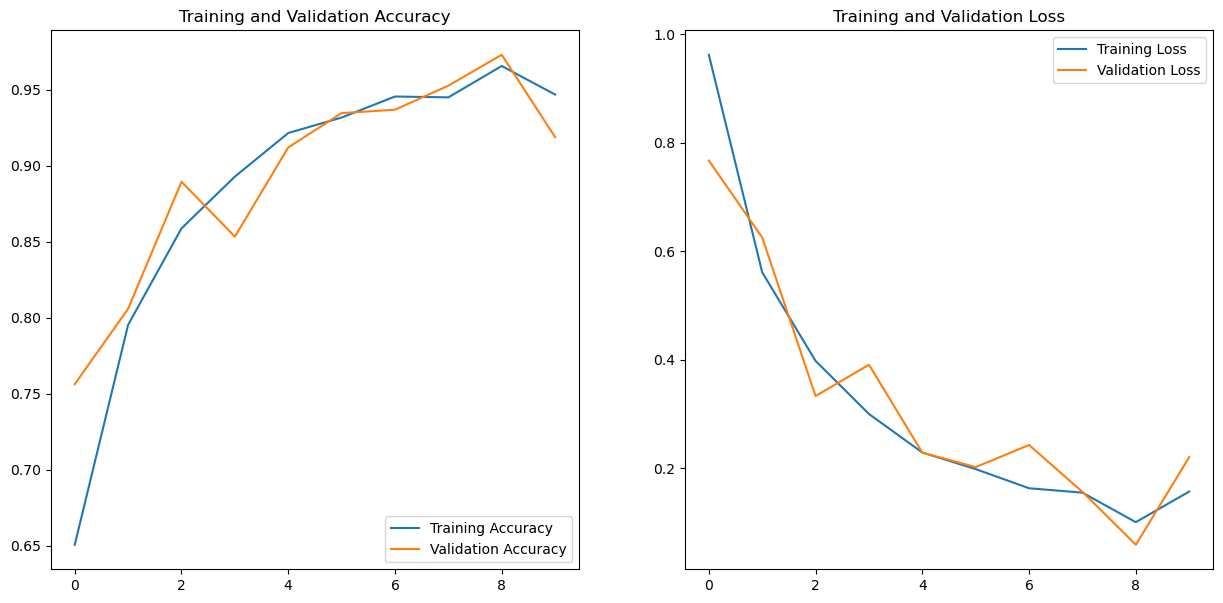

<Figure size 640x480 with 0 Axes>

In [25]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(15, 7))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()
plt.savefig("Accuracy.png")

## Predict on new data

In [26]:
import numpy as np
from keras.preprocessing import image
#test_image = image.load_img('C:/Users/Dell/Arecanut_dataset/test/yellowleafdisease/y1.jpg', target_size = (256, 256))
test_image = image.load_img('C:/Users/Dell/Arecanut_dataset/test/Stem_bleeding/s15.jpg', target_size = (256, 256))
test_image = image.img_to_array(test_image)
test_image = np.expand_dims(test_image, axis = 0)
result = model.predict(test_image)
#train_ds.class_indices
resul = " {} with a {:.2f} ".format(class_names[np.argmax(result)],
                                         100 * np.max(result))
print(resul)

1/1 [==============================] - 0s 109ms/step
 Stem_bleeding with a 80.44 


In [27]:
import numpy as np
from keras.preprocessing import image
test_image = image.load_img('C:/Users/Dell/Arecanut_dataset/test/yellowleafdisease/y1.jpg', target_size = (256, 256))
#test_image = image.load_img('C:/Users/Dell/Arecanut_dataset/test/Stem_bleeding/s15.jpg', target_size = (256, 256))
test_image = image.img_to_array(test_image)
test_image = np.expand_dims(test_image, axis = 0)
result = model.predict(test_image)
#train_ds.class_indices
resul = " {} with a {:.2f} ".format(class_names[np.argmax(result)],
                                         100 * np.max(result))
print(resul)

1/1 [==============================] - 0s 11ms/step
 yellow leaf disease with a 99.99 


In [28]:
import numpy as np
from keras.preprocessing import image
test_image = image.load_img('C:/Users/Dell/Arecanut_dataset/test/stem_cracking/S2.jpg', target_size = (256, 256))
test_image = image.img_to_array(test_image)
test_image = np.expand_dims(test_image, axis = 0)
result = model.predict(test_image)
#train_ds.class_indices
resul = " {} with a {:.2f} ".format(class_names[np.argmax(result)],
                                         100 * np.max(result))
print(resul)

1/1 [==============================] - 0s 31ms/step
 stem cracking with a 97.55 


In [29]:
import numpy as np
from keras.preprocessing import image
test_image = image.load_img('C:/Users/Dell/Arecanut_dataset/test/Mahali_Koleroga/K1.jpg', target_size = (256, 256))
test_image = image.img_to_array(test_image)
test_image = np.expand_dims(test_image, axis = 0)
result = model.predict(test_image)
#train_ds.class_indices
resul = " {} with a {:.2f} ".format(class_names[np.argmax(result)],
                                         100 * np.max(result))
print(resul)

1/1 [==============================] - 0s 23ms/step
 Mahali_Koleroga with a 100.00 


In [ ]:
model.save('Arecanut_dataset/cnn_model.h5')